![Open Screen](https://github.com/Slenderman00/open_screen/blob/master/media/banner.png?raw=true)

### Downloads the dataset

In [1]:
import os
import subprocess
from IPython.display import clear_output

cwd = os.getcwd()
if not os.path.exists(f'{cwd}/dataset'):
    process = subprocess.Popen('bash download_dataset.sh', shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
    for stdout_line in iter(process.stdout.readline, ""):
        clear_output(wait=True)
        print(stdout_line, end="")
    process.stdout.close()
    process.wait()
    assert process.returncode == 0
    print('Finished downloading and extracting')


### Create a custom dataset loader for pytorch

In [2]:
import os
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

image_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize the images to a fixed size
    transforms.ToTensor(),  # Convert the images to tensors
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize the masks to a fixed size
    transforms.Grayscale(),         # Convert masks to grayscale if they are not already
    transforms.ToTensor(),          # Convert the masks to tensors
])

class CustomLoader(Dataset):
    def __init__(self, device='cpu'):
        self.device = device
        self.cwd = os.getcwd()
        self.len = len(os.listdir(f'{self.cwd}/dataset/image'))

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        image_path = f'{self.cwd}/dataset/image/{idx}.jpg'
        mask_path = f'{self.cwd}/dataset/mask/{idx}.png'

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert mask to grayscale

        # Apply the transformations
        image_tensor = image_transform(image).float()
        mask_tensor = mask_transform(mask).float()

        # If mask is not single-channel, take the first channel
        if mask_tensor.size(0) != 1:
            mask_tensor = mask_tensor[0].unsqueeze(0)

        # Move tensors to the specified device
        image_tensor = image_tensor.to(self.device)
        mask_tensor = mask_tensor.to(self.device)

        return {'images': image_tensor, 'masks': mask_tensor}

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleSegmentationModel(nn.Module):
    def __init__(self):
        super(SimpleSegmentationModel, self).__init__()
        # Encoder
        self.enc_conv1a = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc_conv1b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.enc_conv2a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)
        self.enc_conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(256)
        
        # Decoder
        self.dec_conv1a = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_conv1b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(128)
        self.dec_conv2a = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(64)
        self.dec_conv3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def forward(self, x):
        # Encoder
        x1 = F.relu(self.enc_bn1(self.enc_conv1a(x)))
        x1 = F.relu(self.enc_bn1(self.enc_conv1b(x1)))
        x1p = self.pool(x1)
        x2 = F.relu(self.enc_bn2(self.enc_conv2a(x1p)))
        x2 = F.relu(self.enc_bn2(self.enc_conv2b(x2)))
        x2p = self.pool(x2)
        x3 = F.relu(self.enc_bn3(self.enc_conv3a(x2p)))
        x3 = F.relu(self.enc_bn3(self.enc_conv3b(x3)))
        
        # Decoder
        x3u = self.upsample(x3)
        x2d = F.relu(self.dec_bn1(self.dec_conv1a(x3u)))
        x2d = F.relu(self.dec_bn1(self.dec_conv1b(x2d)))
        x1u = self.upsample(x2d)
        x1d = F.relu(self.dec_bn2(self.dec_conv2a(x1u)))
        x1d = F.relu(self.dec_bn2(self.dec_conv2b(x1d)))
        x_out = self.dec_conv3(x1d)
        
        # Output
        x_out = torch.sigmoid(x_out)  # Sigmoid activation to output probabilities
        return x_out

In [4]:
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleSegmentationModel().to(device)

criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
batch_size = 8

In [6]:
from torch.utils.data import DataLoader
# Define your dataset and data loaders for training
train_dataset = CustomLoader(device=device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

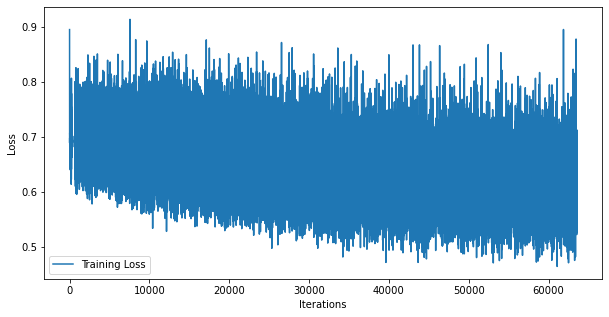

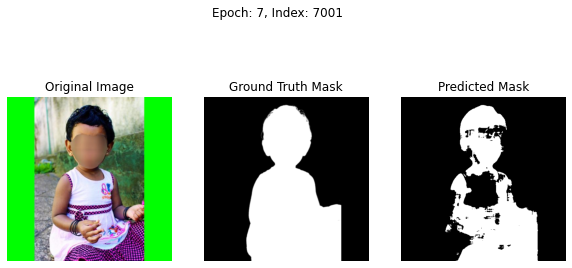

Epoch [7], Loss: 0.5971022844314575


In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot_masks(image, true_mask, pred_mask, epoch, idx):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    true_mask_np = true_mask.squeeze(0).cpu().numpy()
    pred_mask_np = pred_mask.squeeze(0).detach().cpu().numpy()
    
    axs[0].imshow(image_np)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    true_mask_np = true_mask.squeeze().cpu().numpy()
    pred_mask_np = pred_mask.squeeze().detach().cpu().numpy()
    
    axs[1].imshow(true_mask_np, cmap='gray')
    axs[1].set_title('Ground Truth Mask')
    axs[1].axis('off')
    
    axs[2].imshow(pred_mask_np, cmap='gray')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')
    
    plt.suptitle(f'Epoch: {epoch}, Index: {idx}')

# Load the dataset using the CustomLoader
dataset = CustomLoader(device=device)

loss_values = []

for epoch in range(100):
    model.train()
    for i in range(len(dataset)):
        sample = dataset[i]
        images, masks = sample['images'], sample['masks']
        optimizer.zero_grad()
        outputs = model(images.unsqueeze(0))  # Add batch dimension
        loss = criterion(outputs, masks.unsqueeze(0))  # Add batch dimension
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())
        if (i + epoch) % 1000 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(10, 5))
            plt.plot(loss_values, label='Training Loss')
            plt.xlabel('Iterations')
            plt.ylabel('Loss')
            plt.legend()

            pred_mask = outputs > 0.5  # Apply threshold to get binary mask
            plot_masks(images, masks, pred_mask, epoch+1, i+1)
        
            plt.show()
            print(f'Epoch [{epoch+1}], Loss: {loss.item()}')

In [ ]:
# save the model
torch.save(model.state_dict(), 'cnn.pth')
